# Overview

This program uses a standard fully-connected neural network with ReLU activations to predict whether a person is sitting based on their accelerometer data.

In [132]:
import pandas as pd
import numpy as np
import torch
import wandb
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

dev = ""

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)  



## Loading the data into a Pandas dataframe

In [27]:
#Change the data file directory below appropriately
#data = pd.read_csv('../raw_data/FDAA70A1-42A3-4E3F-9AE3-3FDA412E03BF.features_labels.csv')
data = pd.read_csv('../aggregated_data/aggregated_data.csv')
data.head()

,UUID,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,...,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source
0,00EABED2-271D-49D8-B599-1D4A09240601,1444079161,0.996815,0.003529,-0.002786,0.006496,0.995203,0.996825,0.998502,1.748756,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
1,00EABED2-271D-49D8-B599-1D4A09240601,1444079221,0.996864,0.004172,-0.003110,0.007050,0.994957,0.996981,0.998766,1.935573,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
2,00EABED2-271D-49D8-B599-1D4A09240601,1444079281,0.996825,0.003667,0.003094,0.006076,0.994797,0.996614,0.998704,2.031780,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
3,00EABED2-271D-49D8-B599-1D4A09240601,1444079341,0.996874,0.003541,0.000626,0.006059,0.995050,0.996907,0.998690,1.865318,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
4,00EABED2-271D-49D8-B599-1D4A09240601,1444079431,0.997371,0.037653,0.043389,0.102332,0.995548,0.996860,0.998205,0.460806,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2


## Interpolating acceleration columns with average values

In [7]:
def interpolation(df):
    col_to_avg = list(df.columns) #Start with keeping all the columns as columns to use an average interpolation on
    for k in range(len(list(df.columns))):
        if list(df.columns)[k].startswith(('discrete', 'label')): #Remove label and discrete columns from col_to_avg
            col_to_avg.remove(list(df.columns)[k])
    
    df_with_avg = df[col_to_avg].fillna(df[col_to_avg].mean()) #Interpolate nan columns for all continuous-valued columns with average
    
    col_to_zero = list(df.columns)
    for k in range(len(list(df.columns))):
        if not list(df.columns)[k].startswith(('discrete', 'label')): #Remove all columns except label and discrete
            col_to_zero.remove(list(df.columns)[k])
    
    df_with_zero = df[col_to_zero].fillna(0) #Interpolate nan values for label and discrete columns with 0
    
    return pd.concat([df_with_avg, df_with_zero], axis = 1)

In [103]:
X = data.iloc[:,2:28]
#X = data.iloc[:,11:14]
y = data[['label:SITTING']]

X = interpolation(X).values
y = interpolation(y).values

X, y

(array([[ 0.996815,  0.003529, -0.002786, ...,  0.10692 ,  0.516842,
          0.255494],
        [ 0.996864,  0.004172, -0.00311 , ..., -0.079483,  0.357748,
          0.036252],
        [ 0.996825,  0.003667,  0.003094, ...,  0.122432,  0.464881,
          0.222375],
        ...,
        [ 1.026223,  0.195112,  0.25524 , ..., -0.219706,  0.350897,
          0.097009],
        [ 1.123513,  0.27345 ,  0.312818, ..., -0.260843, -0.208532,
          0.58743 ],
        [ 1.020624,  0.135672,  0.104091, ..., -0.131437, -0.004327,
         -0.005321]]),
 array([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]]))

## Splitting the data and loading it into a PyTorch dataloader

In [104]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify=y)

In [105]:
train_features = torch.tensor(X_train)
train_labels = torch.tensor(y_train)
test_features = torch.tensor(X_test)
test_labels = torch.tensor(y_test)

In [120]:
print("Training Volume: " + str(len(train_labels)))
print("Class Ratio for Training: " + str(np.count_nonzero(train_labels == 0)/np.count_nonzero(train_labels == 1)))
print("Testing Volume: " + str(len(test_labels)))
print("Class Ratio for Testing: " + str(np.count_nonzero(test_labels == 0)/np.count_nonzero(test_labels == 1)))

train_features_G = train_features.to(device)
train_labels_G = train_labels.to(device)
test_features_G = test_features.to(device)
test_labels_G = test_labels.to(device)

train_data = torch.utils.data.TensorDataset(train_features, train_labels)
test_data = torch.utils.data.TensorDataset(test_features, test_labels)


train_loader = torch.utils.data.DataLoader(train_data, batch_size = 10000, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 10000, shuffle = True)

Training Volume: 264142
Class Ratio for Training: 1.7673626753554255
Testing Volume: 113204
Class Ratio for Testing: 1.7673503312391523


## Network

In [115]:
class Classifier(nn.Module):
    def __init__(self, input_layer, output_layer):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_layer, 40)
        self.fc2 = nn.Linear(40, 40)
        self.fc3 = nn.Linear(40, 40)
        self.fc4 = nn.Linear(40, 40)
        self.fc5 = nn.Linear(40, 1)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x

In [111]:
input_layer = train_features.shape[1]
output_layer = 1

model = Classifier(input_layer, output_layer)
model.to(torch.device("cuda:0"))

Classifier(
  (fc1): Linear(in_features=26, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=40, bias=True)
  (fc4): Linear(in_features=40, out_features=40, bias=True)
  (fc5): Linear(in_features=40, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

tensor([[ 4.4681e-03,  7.2831e-05,  1.5843e-04,  ..., -4.3800e-04,
         -4.0354e-04,  1.3172e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.7516e-03,  5.3871e-06, -3.1786e-06,  ..., -5.6046e-04,
          9.8493e-05,  6.7314e-05],
        ...,
        [-9.0054e-04, -1.6013e-06, -3.5956e-06,  ...,  2.4573e-04,
         -3.3159e-04, -1.3083e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.2042e-02,  1.2718e-05, -1.0119e-05,  ..., -1.3311e-04,
          3.8012e-04,  7.7079e-04]], device='cuda:0')

In [116]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

## Training loop

In [121]:
epochs = 100
#wandb.init()
#wandb.watch(model)
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        features, labels = batch
        features = features.to(device)
        labels = labels.to(device)
        y_preds = model(features.float())
        loss = criterion(y_preds, labels.float())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    print(f'Epoch: {epoch + 1} | Last Batch Loss: {loss.item()}')
    #wandb.log({'Train Loss': loss.item()/total_loss})

Epoch: 1 | Last Batch Loss: 0.1936998963356018
Epoch: 2 | Last Batch Loss: 0.19293715059757233
Epoch: 3 | Last Batch Loss: 0.18599991500377655
Epoch: 4 | Last Batch Loss: 0.1920299530029297
Epoch: 5 | Last Batch Loss: 0.190599724650383
Epoch: 6 | Last Batch Loss: 0.18994182348251343
Epoch: 7 | Last Batch Loss: 0.18643850088119507
Epoch: 8 | Last Batch Loss: 0.19248540699481964
Epoch: 9 | Last Batch Loss: 0.1897750049829483
Epoch: 10 | Last Batch Loss: 0.1930583119392395
Epoch: 11 | Last Batch Loss: 0.19188250601291656
Epoch: 12 | Last Batch Loss: 0.18714973330497742
Epoch: 13 | Last Batch Loss: 0.1843656748533249
Epoch: 14 | Last Batch Loss: 0.1913478672504425
Epoch: 15 | Last Batch Loss: 0.1892034262418747
Epoch: 16 | Last Batch Loss: 0.18791563808918
Epoch: 17 | Last Batch Loss: 0.1856926530599594
Epoch: 18 | Last Batch Loss: 0.19292697310447693
Epoch: 19 | Last Batch Loss: 0.18942265212535858
Epoch: 20 | Last Batch Loss: 0.19267410039901733
Epoch: 21 | Last Batch Loss: 0.18952015042

## Evaluating the model

In [122]:
total_wrong = 0
positive_preds = 0 #tp + fp
true_positives = 0
false_negatives = 0

with torch.no_grad():
    for X_test_data, y_test in test_loader:
        y_test_preds = model(X_test_data.float().to(device))
        y_test_preds = torch.round(y_test_preds)

        for k in range(len(y_test_preds)):
            if y_test_preds[k].item() == 1:
                positive_preds += 1
            if y_test_preds[k].item() == y_test[k].item() == 1:
                true_positives += 1
            if y_test_preds[k].item() == 0 and y_test[k].item() == 1:
                false_negatives += 1

        current_wrong = (abs(y_test_preds - y_test.to(device))).sum().item()
        total_wrong += current_wrong

    class_acc = (len(X_test) - total_wrong) / len(X_test) * 100
    if positive_preds == 0:
        precision = true_positives / positive_preds + 0.001
    else:
        precision = true_positives / positive_preds
    recall = true_positives / (true_positives + false_negatives)

    print(f'Classification Accuracy: {class_acc:.2f}')
    print(f'Precision: {precision:.2f}') #What percentage of a model's positive predictions were actually positive
    print(f'Recall: {recall:.2f}') #What percent of the true positives were identified
    print(f'F-1 Score: {2*(precision * recall / (precision + recall)):.2f}')

Classification Accuracy: 70.72
Precision: 0.61
Recall: 0.52
F-1 Score: 0.56


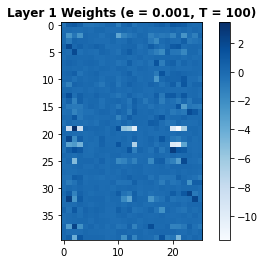

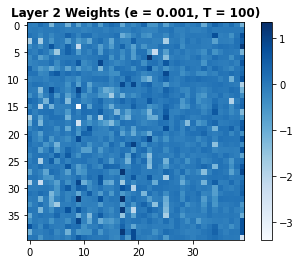

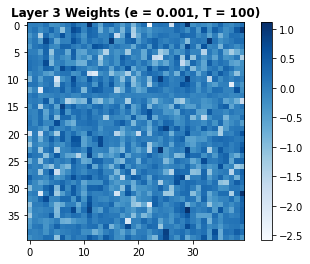

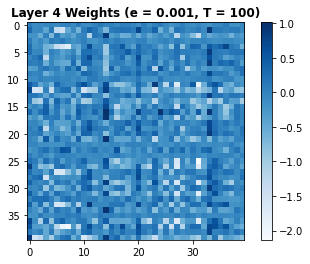

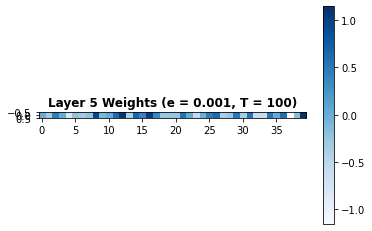

In [149]:
#Layer 1
w_img = model.fc1.weight
wmin = torch.min(w_img)
wmax = torch.max(w_img)
w_img = w_img.cpu()
w_img = w_img.detach().numpy()
#w_img = w_img.reshape(26, 40)
c = plt.imshow(w_img, cmap ='Blues', vmin = wmin , vmax = wmax,
                    interpolation ='nearest', origin ='upper')
plt.colorbar(c)
plt.title('Layer 1 Weights (e = 0.001, T = 100)', fontweight ="bold")
plt.show()

#layer 2
w_img = model.fc2.weight
wmin = torch.min(w_img)
wmax = torch.max(w_img)
w_img = w_img.cpu()
w_img = w_img.detach().numpy()
#w_img = w_img.reshape(26, 40)
c = plt.imshow(w_img, cmap ='Blues', vmin = wmin , vmax = wmax,
                    interpolation ='nearest', origin ='upper')
plt.colorbar(c)
plt.title('Layer 2 Weights (e = 0.001, T = 100)', fontweight ="bold")
plt.show()

#Layer 3
w_img = model.fc3.weight
wmin = torch.min(w_img)
wmax = torch.max(w_img)
w_img = w_img.cpu()
w_img = w_img.detach().numpy()
#w_img = w_img.reshape(26, 40)
c = plt.imshow(w_img, cmap ='Blues', vmin = wmin , vmax = wmax,
                    interpolation ='nearest', origin ='upper')
plt.colorbar(c)
plt.title('Layer 3 Weights (e = 0.001, T = 100)', fontweight ="bold")
plt.show()

#Layer 4
w_img = model.fc4.weight
wmin = torch.min(w_img)
wmax = torch.max(w_img)
w_img = w_img.cpu()
w_img = w_img.detach().numpy()
#w_img = w_img.reshape(26, 40)
c = plt.imshow(w_img, cmap ='Blues', vmin = wmin , vmax = wmax,
                    interpolation ='nearest', origin ='upper')
plt.colorbar(c)
plt.title('Layer 4 Weights (e = 0.001, T = 100)', fontweight ="bold")
plt.show()


#Layer 5
w_img = model.fc5.weight
wmin = torch.min(w_img)
wmax = torch.max(w_img)
w_img = w_img.cpu()
w_img = w_img.detach().numpy()
#w_img = w_img.reshape(26, 40)
c = plt.imshow(w_img, cmap ='Blues', vmin = wmin , vmax = wmax,
                    interpolation ='nearest', origin ='upper')
plt.colorbar(c)
plt.title('Layer 5 Weights (e = 0.001, T = 100)', fontweight ="bold")
plt.show()